# Produce covariances from xs reconstruction rule

In [1]:
import sandy

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

Cr-50 from JEFF-3.3 was identified as having covariance matrices (MF33) for the partial components of neutron inelastic scattering - i.e., MT=51-70 - but not for the MT=4.

## Plotting covariance matrices available in ENDF-6 file

In [4]:
mts = range(51, 56)  # only 5 reactions are selected

In [5]:
errorr = sandy.get_endf6_file("jeff_33", "xs", 240500).get_errorr(
    err=0.1,
    mt=mts,
    irespr=0,  # faster
    ek_errorr=[1e6, 2e6, 5e6, 1e7, 2e7],  # only above threshold
)
cov = errorr.get_cov()

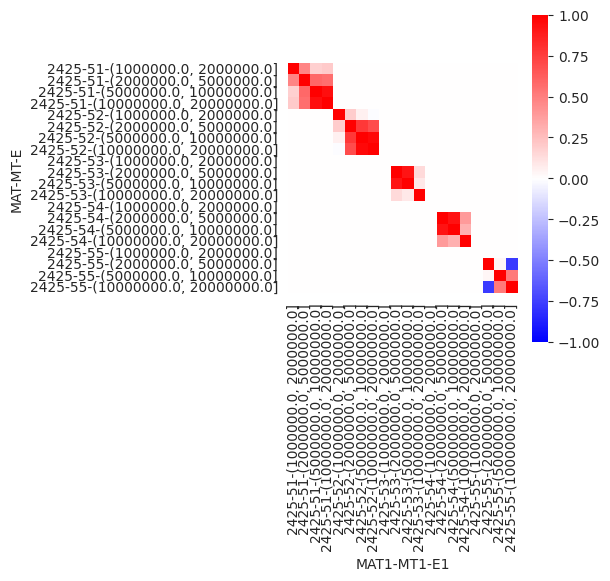

In [6]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.set_aspect("equal")
sns.heatmap(data=cov.get_corr().data, ax=ax, cmap="bwr", vmin=-1, vmax=1)
fig.tight_layout()

## Trasnfering covariance info to random xs samples

In [7]:
tape = sandy.get_endf6_file("jeff_33", "xs", 240500).get_pendf(err=0.1)
xs = sandy.Xs.from_endf6(tape)

INFO:  Zero or no temperature was requested, NJOY processing will stop after RECONR.
If you want to process 0K cross sections use `temperature=0.1`.



### Sampling cross sections **WITHOUT** reconstructing redundant cross section.

In [8]:
perts = cov.sampling(50).data.T

data = []
for smp, pert in perts.iteritems():
    pert = pert.rename("PERT").reset_index().pivot_table(index="E", columns=("MAT", "MT"), values="PERT")
    eindex = [pert.index.left.to_list()[0]] + pert.index.right.to_list()
    dim = pert.shape[1]
    values = [[1] * dim] + pert.values.tolist()
    df = pd.DataFrame(values, index=eindex, columns=pert.columns)
    xsnew = sandy.Xs(xs.data)
    for (mat, mt), p in df.iteritems():
        p = sandy.Pert(p)
        mat, mt = p.data.name
        xsnew = xsnew.custom_perturbation(mat, mt, p)
    data.append(xsnew.data.unstack().rename("XS").reset_index().assign(SMP=smp))
data = pd.concat(data, ignore_index=True)

filtered_data = data[data.MT.isin([4, 51, 52, 53])].query("E>7.9E5 & E<2e7")

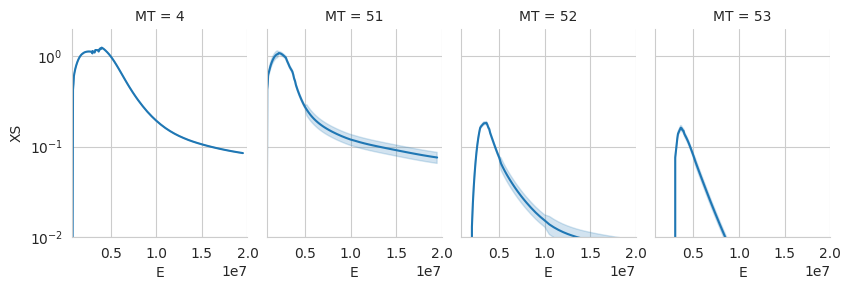

In [9]:
g = sns.relplot(
    data=filtered_data,
    x="E",
    y="XS",
    col="MT",
    kind="line",
    height=3, aspect=.7,
    ci="sd",
)
g.set(yscale="log", xlim=(7.9e5, 2e7), ylim=(1e-2, 2))
g.figure.set_dpi(100);

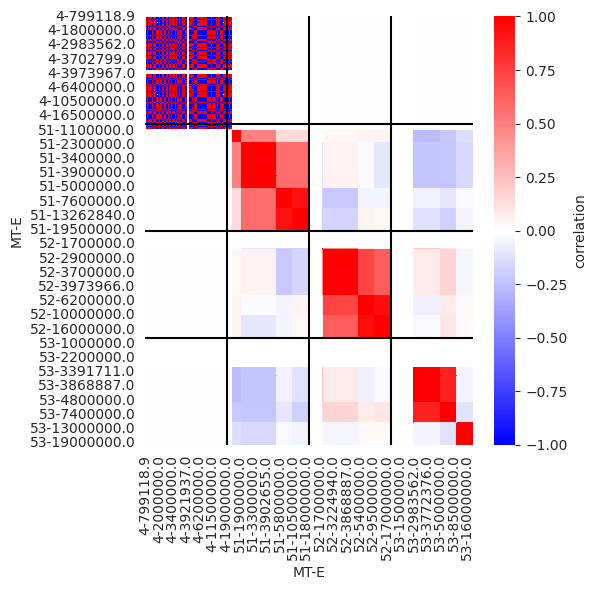

In [10]:
corr = filtered_data.pivot_table(index="SMP", columns=("MT", "E"), values="XS").corr()

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1, cbar_kws={'label': 'correlation'})
ax.axhline(98 * 1, color='k')
ax.axvline(98 * 1, color='k')
ax.axhline(98 * 2, color='k')
ax.axvline(98 * 2, color='k')
ax.axhline(98 * 3, color='k')
ax.axvline(98 * 3, color='k')

fig.tight_layout()

### Sampling cross sections **AND** reconstructing redundant cross section.

In [11]:
perts = cov.sampling(50).data.T

data = []
for smp, pert in perts.iteritems():
    pert = pert.rename("PERT").reset_index().pivot_table(index="E", columns=("MAT", "MT"), values="PERT")
    eindex = [pert.index.left.to_list()[0]] + pert.index.right.to_list()
    dim = pert.shape[1]
    values = [[1] * dim] + pert.values.tolist()
    df = pd.DataFrame(values, index=eindex, columns=pert.columns)
    xsnew = sandy.Xs(xs.data)
    for (mat, mt), p in df.iteritems():
        p = sandy.Pert(p)
        mat, mt = p.data.name
        xsnew = xsnew.custom_perturbation(mat, mt, p)
    data.append(xsnew._reconstruct_sums().data.unstack().rename("XS").reset_index().assign(SMP=smp))
data = pd.concat(data, ignore_index=True)

filtered_data2 = data[data.MT.isin([4, 51, 52, 53])].query("E>7.9E5 & E<2e7")

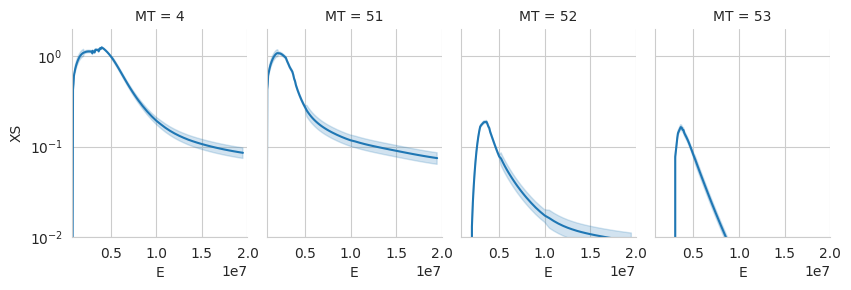

In [12]:
g = sns.relplot(
    data=filtered_data2,
    x="E",
    y="XS",
    col="MT",
    kind="line",
    height=3, aspect=.7,
    ci="sd",
)
g.set(yscale="log", xlim=(7.9e5, 2e7), ylim=(1e-2, 2))
g.figure.set_dpi(100);

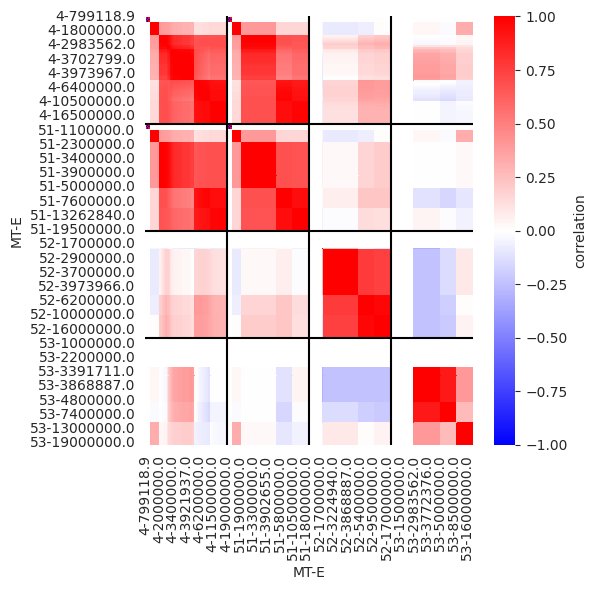

In [13]:
corr = filtered_data2.pivot_table(index="SMP", columns=("MT", "E"), values="XS").corr()

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
sns.heatmap(corr, cmap='bwr', vmin=-1, vmax=1, cbar_kws={'label': 'correlation'})
ax.axhline(98 * 1, color='k')
ax.axvline(98 * 1, color='k')
ax.axhline(98 * 2, color='k')
ax.axvline(98 * 2, color='k')
ax.axhline(98 * 3, color='k')
ax.axvline(98 * 3, color='k')

fig.tight_layout()